In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import *
from dateutil.relativedelta import *
import os
from collections import Counter
from scipy.stats import sem, t
from scipy.stats import entropy
import seaborn as sns
import ast

### First, let's explore the Goodreads actions data over time

In [2]:
data_path = '../data/'
OUTPUT_BASE_PATH = '../outputs'

data_step_size = 1
rec_step_size = 2

date_rec_added = pd.to_datetime('2011-09-15')
date_rec_added - pd.to_timedelta('1W')

popular_metrics_path = f'{OUTPUT_BASE_PATH}/plots/popular/{rec_step_size}step_metrics.csv'
implicitmf_metrics_path = f'{OUTPUT_BASE_PATH}/plots/implicitmf/{rec_step_size}step_metrics.csv'
itemknn_metrics_path = f'{OUTPUT_BASE_PATH}/plots/itemknn/{rec_step_size}step_metrics.csv'
bpr_metrics_path = f'{OUTPUT_BASE_PATH}/plots/bpr/{rec_step_size}step_metrics.csv'
data_metrics_path = f'{OUTPUT_BASE_PATH}/data_stat/{data_step_size}step_metrics.csv'

In [3]:
popular_metrics= pd.read_csv(popular_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})

implicitmf_metrics= pd.read_csv(implicitmf_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})

itemknn_metrics= pd.read_csv(itemknn_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})
bpr_metrics= pd.read_csv(bpr_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})

data_metrics= pd.read_csv(data_metrics_path, parse_dates=[0, 1])
popular_metrics.head()

,start_date,end_date,ndcg,ndcg_ci,rbp,rbp_ci,reciprank,reciprank_ci,book_gini,book_exposure_gini,...,gender_prop,gender_prop_binary,unique_user_train,unique_item_train,unique_user_test,unique_item_test,unique_item_recs_frac,unique_item_recs,unique_user_recs,unique_author_recs
0,2007-01-01,2009-03-01,0.045307,0.001299,0.021619,0.001129,0.055394,0.002419,0.999508,0.999918,...,"{'male': 0.33063542361574383, 'female': 0.1637...","{'male': 0.66879460058789, 'female': 0.3312053...",37361,234914,17988,86621,0.000183,329,17988,238
1,2007-03-01,2009-05-01,0.043293,0.001266,0.022032,0.001128,0.054284,0.002315,0.999541,0.999923,...,"{'male': 0.33559450171821303, 'female': 0.1635...","{'male': 0.6723983606783123, 'female': 0.32760...",42327,252520,18915,89538,0.000178,336,18915,242
2,2007-05-01,2009-07-01,0.043996,0.001268,0.023608,0.001133,0.059186,0.002424,0.999565,0.999927,...,"{'male': 0.3507033432893342, 'female': 0.16309...","{'male': 0.6825640006300677, 'female': 0.31743...",46632,268098,20758,90010,0.000163,338,20758,248
3,2007-07-01,2009-09-01,0.046761,0.001241,0.024957,0.001081,0.063606,0.002370,0.999582,0.999929,...,"{'male': 0.3447491187606075, 'female': 0.17738...","{'male': 0.6602632221586018, 'female': 0.33973...",51319,281082,22979,93389,0.000148,339,22979,252
4,2007-09-01,2009-11-01,0.036902,0.001091,0.017791,0.000874,0.047600,0.001981,0.999596,0.999932,...,"{'male': 0.336711124583207, 'female': 0.178379...","{'male': 0.653692857244941, 'female': 0.346307...",56231,292278,23093,91181,0.000155,358,23093,261


## Unique Count of Entities

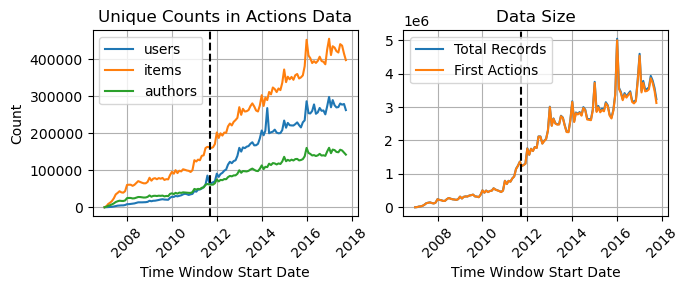

In [4]:
rows = 1
columns = 2

fig, axes = plt.subplots(rows, columns, figsize=(7, 3))


# unique number of users, items, and authors
axes[0].plot(data_metrics['start_date'], data_metrics['unique_user_count'], label='users')
axes[0].plot(data_metrics['start_date'], data_metrics['unique_item_count'], label='items')
axes[0].plot(data_metrics['start_date'], data_metrics['unique_author_count'], label='authors')
axes[0].axvline(date_rec_added, color='black', linestyle='--')
axes[0].set_title("Unique Counts in Actions Data")
axes[0].set_xlabel("Time Window Start Date")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(data_metrics['start_date'], data_metrics['data_size'], label='Total Records')
axes[1].plot(data_metrics['start_date'], data_metrics['first_interaction_count'], label='First Actions') # # of unique user,item pairs
axes[1].axvline(date_rec_added, color='black', linestyle='--')
axes[1].set_title("Data Size")
axes[1].set_xlabel("Time Window Start Date")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(True)


plt.tight_layout()
plt.savefig('unique_count.png', dpi=300, bbox_inches='tight')
plt.show()

## Diversity: Genre Entropy

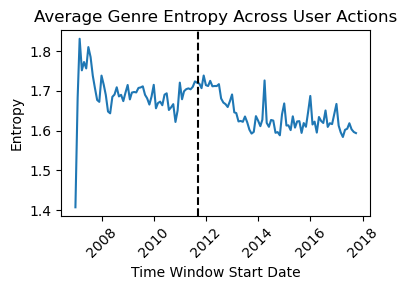

In [14]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(data_metrics['start_date'], data_metrics['genre_entropy']) 

ax.axvline(date_rec_added, color='black', linestyle='--')
ax.set_title("Average Genre Entropy Across User Actions")
ax.set_xlabel("Time Window Start Date")
ax.set_ylabel("Entropy")
ax.tick_params(axis='x', rotation=45)

plt.savefig('entropy.png', dpi=300, bbox_inches='tight')
plt.tight_layout()  
plt.show()

## Individual Item & Author Fairness: Gini 

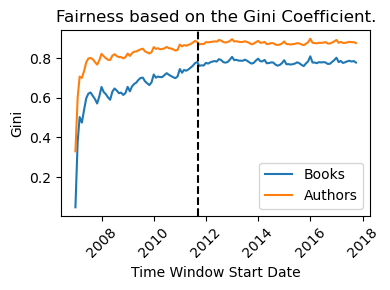

In [6]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(data_metrics['start_date'], data_metrics['book_gini'], label="Books") 
ax.plot(data_metrics['start_date'], data_metrics['author_gini'], label="Authors") 

ax.axvline(date_rec_added, color='black', linestyle='--')
ax.set_title("Fairness based on the Gini Coefficient.")
ax.set_xlabel("Time Window Start Date")
ax.set_ylabel("Gini")
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.savefig('gini.png', dpi=300, bbox_inches='tight')
plt.tight_layout()  
plt.show()

## Author Gender Representation: Female Prop

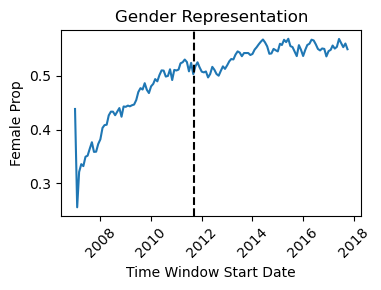

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(data_metrics['start_date'], data_metrics['female_binary']) 

ax.axvline(date_rec_added, color='black', linestyle='--')
ax.set_title("Gender Representation")
ax.set_xlabel("Time Window Start Date")
ax.set_ylabel("Female Prop")
ax.tick_params(axis='x', rotation=45)

plt.savefig('female_prop.png', dpi=300, bbox_inches='tight')
plt.tight_layout()  
plt.show()

### Now, Let's evaluate recommendations over time

## Effectiveness: RBP

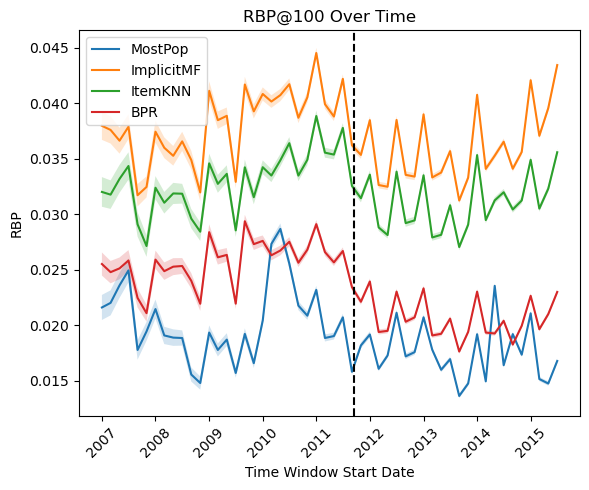

In [8]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(popular_metrics['start_date'], popular_metrics['rbp'], label='MostPop')  
ax.fill_between(popular_metrics['start_date'],
                   popular_metrics['rbp'] - popular_metrics['rbp_ci'],
                   popular_metrics['rbp'] + popular_metrics['rbp_ci'],
                   alpha=0.2)

ax.plot(implicitmf_metrics['start_date'], implicitmf_metrics['rbp'], label='ImplicitMF')  
ax.fill_between(implicitmf_metrics['start_date'],
                   implicitmf_metrics['rbp'] - implicitmf_metrics['rbp_ci'],
                   implicitmf_metrics['rbp'] + implicitmf_metrics['rbp_ci'],
                   alpha=0.2)

ax.plot(itemknn_metrics['start_date'], itemknn_metrics['rbp'], label='ItemKNN')  
ax.fill_between(itemknn_metrics['start_date'],
                   itemknn_metrics['rbp'] - itemknn_metrics['rbp_ci'],
                   itemknn_metrics['rbp'] + itemknn_metrics['rbp_ci'],
                   alpha=0.2)

ax.plot(bpr_metrics['start_date'], bpr_metrics['rbp'], label='BPR')  
ax.fill_between(bpr_metrics['start_date'],
                   bpr_metrics['rbp'] - bpr_metrics['rbp_ci'],
                   bpr_metrics['rbp'] + bpr_metrics['rbp_ci'],
                   alpha=0.2)

ax.axvline(date_rec_added, color='black', linestyle='--')
ax.set_title("RBP@100 Over Time")
ax.set_xlabel("Time Window Start Date")
ax.set_ylabel("RBP")
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.savefig('rbp.png', dpi=300, bbox_inches='tight')
plt.tight_layout()  
plt.show()

## Unique Count of Entities

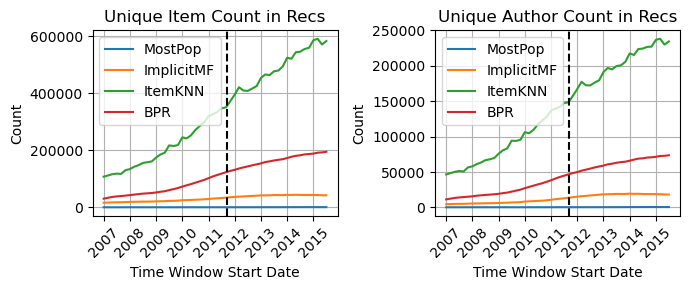

In [9]:
rows = 1
columns = 2

fig, axes = plt.subplots(rows, columns, figsize=(7, 3))


# unique number of items 
axes[0].plot(popular_metrics['start_date'], popular_metrics['unique_item_recs'], label='MostPop')
axes[0].plot(implicitmf_metrics['start_date'], implicitmf_metrics['unique_item_recs'], label='ImplicitMF')
axes[0].plot(itemknn_metrics['start_date'], itemknn_metrics['unique_item_recs'], label='ItemKNN')
axes[0].plot(bpr_metrics['start_date'], bpr_metrics['unique_item_recs'], label='BPR')
axes[0].axvline(date_rec_added, color='black', linestyle='--')
axes[0].set_title("Unique Item Count in Recs")
axes[0].set_xlabel("Time Window Start Date")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(True)

# unique number of authors 
axes[1].plot(popular_metrics['start_date'], popular_metrics['unique_author_recs'], label='MostPop')
axes[1].plot(implicitmf_metrics['start_date'], implicitmf_metrics['unique_author_recs'], label='ImplicitMF')
axes[1].plot(itemknn_metrics['start_date'], itemknn_metrics['unique_author_recs'], label='ItemKNN')
axes[1].plot(bpr_metrics['start_date'], bpr_metrics['unique_author_recs'], label='BPR')
axes[1].axvline(date_rec_added, color='black', linestyle='--')
axes[1].set_title("Unique Author Count in Recs")
axes[1].set_xlabel("Time Window Start Date")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(True)

# unique number of users  (if needed)------------
# axes[1,0].plot(gender_df_popular['start_date'], gender_df_popular['unique_user_recs'], label='MostPop')
# axes[1,0].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['unique_user_recs'], label='ImplicitMF')
# axes[1,0].plot(gender_df_itemknn['start_date'], gender_df_itemknn['unique_user_recs'], label='ItemKNN')
# axes[1,0].plot(gender_df_bpr['start_date'], gender_df_bpr['unique_user_recs'], label='BPR')
# axes[1,0].axvline(date_rec_added, color='black', linestyle='--')
# axes[1,0].set_title("Unique User Count in Recommendations")
# axes[1,0].set_xlabel("Time Window Start Date")
# axes[1,0].set_ylabel("Count")
# axes[1,0].tick_params(axis='x', rotation=45)
# axes[1,0].legend()
# axes[1,0].grid(True)




plt.tight_layout()
plt.savefig('unique_count_rec.png', dpi=300, bbox_inches='tight')
plt.show()

## Diversity: Genre Entropy

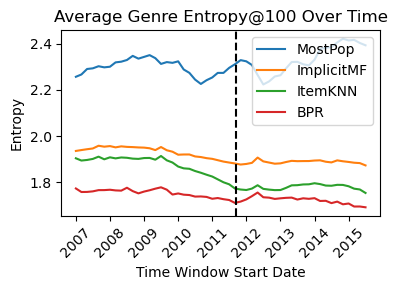

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(popular_metrics['start_date'], popular_metrics['genre_entropy'], label='MostPop') 
ax.plot(implicitmf_metrics['start_date'], implicitmf_metrics['genre_entropy'], label='ImplicitMF') 
ax.plot(itemknn_metrics['start_date'], itemknn_metrics['genre_entropy'], label='ItemKNN') 
ax.plot(bpr_metrics['start_date'], bpr_metrics['genre_entropy'], label='BPR') 

ax.axvline(date_rec_added, color='black', linestyle='--')
ax.set_title("Average Genre Entropy@100 Over Time")
ax.set_xlabel("Time Window Start Date")
ax.set_ylabel("Entropy")
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.savefig('entropy_rec.png', dpi=300, bbox_inches='tight')
plt.tight_layout()  
plt.show()

## Individual Item & Author Fairness: Gini 

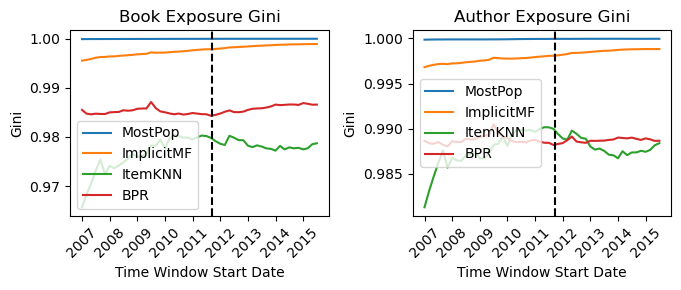

In [11]:
rows = 1
columns = 2

fig, axes = plt.subplots(rows, columns, figsize=(7, 3))

# book exposure gini
axes[0].plot(popular_metrics['start_date'], popular_metrics['book_exposure_gini'], label='MostPop') 
axes[0].plot(implicitmf_metrics['start_date'], implicitmf_metrics['book_exposure_gini'], label='ImplicitMF') 
axes[0].plot(itemknn_metrics['start_date'], itemknn_metrics['book_exposure_gini'], label='ItemKNN') 
axes[0].plot(bpr_metrics['start_date'], bpr_metrics['book_exposure_gini'], label='BPR') 
axes[0].axvline(date_rec_added, color='black', linestyle='--')
axes[0].set_title("Book Exposure Gini")
axes[0].set_xlabel("Time Window Start Date")
axes[0].set_ylabel("Gini")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# author exposure gini
axes[1].plot(popular_metrics['start_date'], popular_metrics['author_gini'], label='MostPop') 
axes[1].plot(implicitmf_metrics['start_date'], implicitmf_metrics['author_gini'], label='ImplicitMF') 
axes[1].plot(itemknn_metrics['start_date'], itemknn_metrics['author_gini'], label='ItemKNN') 
axes[1].plot(bpr_metrics['start_date'], bpr_metrics['author_gini'], label='BPR') 
axes[1].axvline(date_rec_added, color='black', linestyle='--')
axes[1].set_title("Author Exposure Gini")
axes[1].set_xlabel("Time Window Start Date")
axes[1].set_ylabel("Gini")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

plt.savefig('gini_rec.png', dpi=300, bbox_inches='tight')
plt.tight_layout()  
plt.show()

## Author Gender Representation: Female Prop

In [12]:
# unfold gender data for popular
gender_popular = popular_metrics['gender_prop'].apply(pd.Series)
gender_binary_popular = popular_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_popular.columns = ['male_binary', 'female_binary']

# unfold gender data for implicitmf
gender_implicitmf = implicitmf_metrics['gender_prop'].apply(pd.Series)
gender_binary_implicitmf = implicitmf_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_implicitmf.columns = ['male_binary', 'female_binary']

# unfold gender data for itemknn
gender_itemknn = itemknn_metrics['gender_prop'].apply(pd.Series)
gender_binary_itemknn = itemknn_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_itemknn.columns = ['male_binary', 'female_binary']

# unfold gender data for bpr
gender_bpr = bpr_metrics['gender_prop'].apply(pd.Series)
gender_binary_bpr = bpr_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_bpr.columns = ['male_binary', 'female_binary']

gender_binary_bpr.head()

,male_binary,female_binary
0,0.596088,0.403912
1,0.586664,0.413336
2,0.576378,0.423622
3,0.575029,0.424971
4,0.569015,0.430985


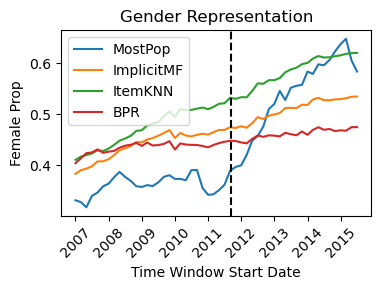

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(popular_metrics['start_date'], gender_binary_popular['female_binary'], label='MostPop') 
ax.plot(implicitmf_metrics['start_date'], gender_binary_implicitmf['female_binary'], label='ImplicitMF') 
ax.plot(itemknn_metrics['start_date'], gender_binary_itemknn['female_binary'], label='ItemKNN') 
ax.plot(bpr_metrics['start_date'], gender_binary_bpr['female_binary'], label='BPR') 

ax.axvline(date_rec_added, color='black', linestyle='--')
ax.set_title("Gender Representation")
ax.set_xlabel("Time Window Start Date")
ax.set_ylabel("Female Prop")
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.savefig('female_prop_rec.png', dpi=300, bbox_inches='tight')
plt.tight_layout()  
plt.show()